In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

from pclib.nn.models import ConvClassifierUs
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y, identity, shrinkage
from pclib.utils.customdataset import PreloadedDataset
from tqdm import tqdm
from pclib.optim.train import val_pass

In [2]:
seed = 42
# For reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(seed)

# Scale img transform
class Scale(object):
    def __init__(self, scale_factor):
        self.scale_factor = scale_factor

    def __call__(self, img):
        return img * self.scale_factor + 0.5 * (1 - self.scale_factor)

# Inverse Logistic Sigmoid Transform
class InvLogit(object):
    def __call__(self, x):
        return torch.log(x / (1 - x))

# Pad Transform
class Pad(object):
    def __init__(self, padding):
        self.padding = padding

    def __call__(self, img):
        return F.pad(img, self.padding, 'constant', 0)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # Pad((2, 2, 2, 2)),
    # Scale(0.9),
    # InvLogit(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    # transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # Pad((2, 2, 2, 2)),
    # Scale(0.9),
    # InvLogit(),
    # transforms.Normalize((0.1307,), (0.3081,)),
])

dataset = datasets.CIFAR10('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
subset = 40
dataset = torch.utils.data.Subset(dataset, range(subset))

train_dataset = PreloadedDataset.from_dataset(dataset, train_transform, device)

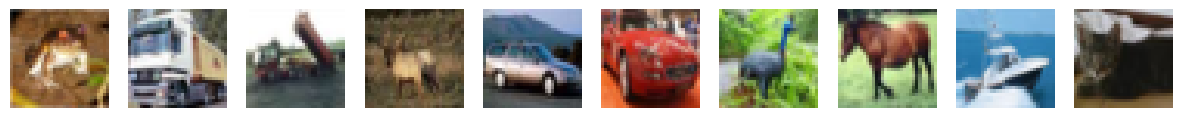

Max value:  tensor(1., device='cuda:0')
Min value:  tensor(0., device='cuda:0')


In [4]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    # ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.imshow(img.squeeze().cpu().permute(1, 2, 0))
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [5]:
all_stats = {}

In [9]:
def train(
        model,
        train_dataset,
        NUM_EPOCHS,
        optimiser,
        scheduler,
        stats,
        norm_grads=False,
        neg_cnst=0.0,
        cd=0,
):

    pos_state = model.init_state(train_dataset.transformed_images)
    neg_state = model.init_state(train_dataset.transformed_images)

    model.train()
    gamma = torch.ones(pos_state[0]['x'].shape[0], device=device) * 0.2
    cd_gamma = torch.ones(pos_state[0]['x'].shape[0], device=device) * 0.2

    loop = tqdm(range(NUM_EPOCHS), leave=False)
    for i in loop:

        # TQDM loop
        if stats['epoch'] > 0:
            postfix = {'steps': i, 'posVFE': stats['posVfe'][-1]}
            if neg_cnst > 0:
                postfix['negVFE'] = stats['negVfe'][-1]
            if cd > 0:
                postfix['cd'] = stats['cd'][-1]
            loop.set_postfix(postfix)

        model.step(pos_state, gamma=gamma, pin_obs=True)
        pos_vfe = model.vfe(pos_state, normalise=norm_grads)
        loss = pos_vfe

        # Same For Negative particles
        if neg_cnst > 0:
            model.step(neg_state, gamma=gamma, pin_obs=False)
            neg_vfe = model.vfe(neg_state, normalise=norm_grads)
            loss -= neg_cnst*neg_vfe
        if cd > 0:
            cd_state = [{k: v.clone() for k, v in state_l.items()} for state_l in pos_state]
            # for _ in range(cd):
            #     model.step(cd_state, cd_gamma, pin_obs=False)
            
            out, _ = model.reconstruct(cd_state[0]['x'], steps=cd)
            cd_state[0]['x'] = out

            cd_vfe = model.vfe(cd_state, normalise=norm_grads)
            loss += -0.75 * cd_vfe

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        if model.has_top:
            model.top.weight.data = model.top.weight.data - torch.diag(model.top.weight.data.diag()).data

        # if norm_grads, recalculate VFE WITHOUT normalisation for plotting (otherwise it will be constant)
        if norm_grads:
            pos_vfe = model.vfe(pos_state, normalise=False)
            if neg_cnst:
                neg_vfe = model.vfe(neg_state, normalise=False)

        # Track epoch stats
        stats['posVfe'].append(pos_vfe.item())
        if neg_cnst > 0:
            stats['negVfe'].append(neg_vfe.item())

        # Update learning rate
        if scheduler is not None:
            scheduler.step(stats['posVfe'][-1])
        
        stats['epoch'] += 1
    
def train_classifier(
        model,
        classifier,
        NUM_EPOCHS,
        train_dataset,
        val_dataset,
        stats,
):
    # Init data
    trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True)
    valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=200, shuffle=False)

    for i in range(NUM_EPOCHS):

        # Epoch stats
        epochLosses = []

        optimiser = torch.optim.AdamW(classifier.parameters(), lr=0.001)  

        # TQDM loop
        loop = tqdm(trainLoader, total=len(trainLoader), leave=False)
        loop.set_description('Epoch [{}/{}]'.format(i, NUM_EPOCHS))
        if stats['epoch'] > 0:
            loop.set_postfix({'steps': i, 'valAcc': stats['valAcc'][-1], 'valLoss': stats['valLoss'][-1]})

        # Iterate over all batches
        for (images, labels) in loop:
            images = images.flatten(1)

            out, state = model(images)
            out = classifier(out)

            model.zero_grad()
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimiser.step()
            epochLosses.append(loss.item())

        # Track epoch stats
        stats['trainLoss'].append(torch.tensor(epochLosses).mean())

        # Update learning rate
        # if scheduler is not None:
        #     scheduler.step(stats['ValAcc'][-1])

        # Validation pass
        val_results = val_pass(model, None, valLoader, True, True, None)
        stats['valAcc'].append(val_results['acc'].item())
        stats['valLoss'].append(val_results['loss'].item())
        
        stats['epoch'] += 1

In [19]:
torch.manual_seed(seed)

model_name = 'original'
model = ConvClassifierUs( 
    in_channels=3,
    bias=True, 
    symmetric=True, 
    actv_fn=F.relu,
    steps=20,
    gamma=0.2,
    x_decay=0.0,
    has_top=True,
).to(device)
stats = {
    'epoch': 0,
    'posVfe': [],
    'negVfe': [],
    'valVfe': [],
    'valAcc': [],
}

In [20]:
BATCH_SIZE = 40
NUM_EPOCHS = 100000
optimiser = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.02)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=25, factor=0.5, verbose=True, threshold=1e-4, min_lr=1e-9)
train(
    model,
    train_dataset,
    NUM_EPOCHS,
    optimiser,
    None,
    stats,
    norm_grads=False,
    neg_cnst=0.0,
    cd=0,
)

In [21]:
all_stats['classic'] = stats

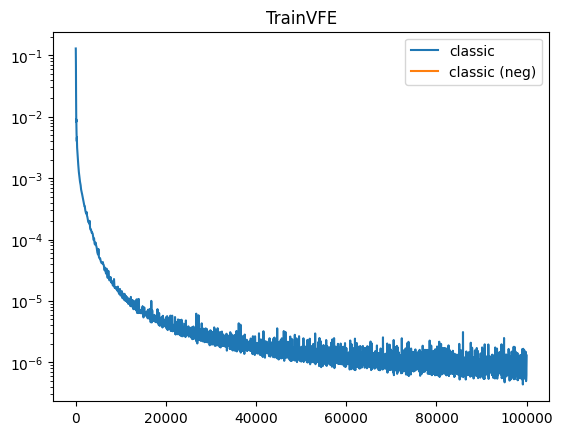

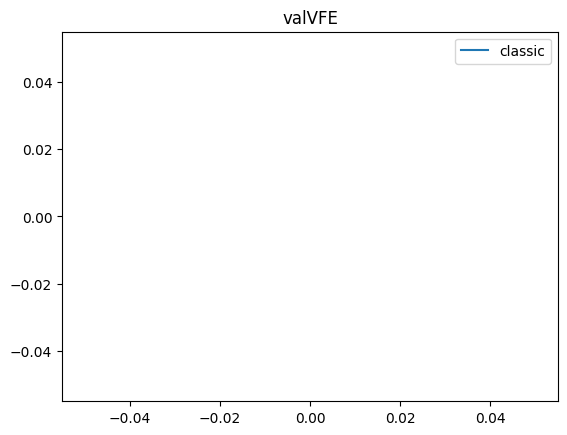

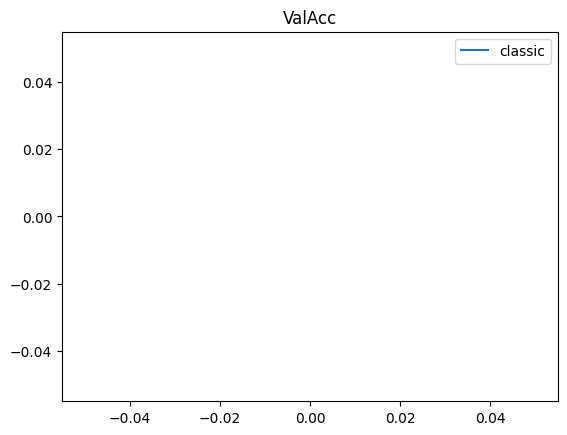

In [22]:
for k, v in all_stats.items():
    plt.plot(v['posVfe'], label=k)
    plt.plot(v['negVfe'], label=k+' (neg)')
plt.legend()
plt.yscale('log')
plt.title('TrainVFE')
plt.show()

for k, v in all_stats.items():
    plt.plot(v['valVfe'], label=k)
plt.legend()
plt.title('valVFE')
plt.show()

for k, v in all_stats.items():
    plt.plot(v['valAcc'], label=k)
plt.legend()
plt.title('ValAcc')
# plt.yscale('log')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

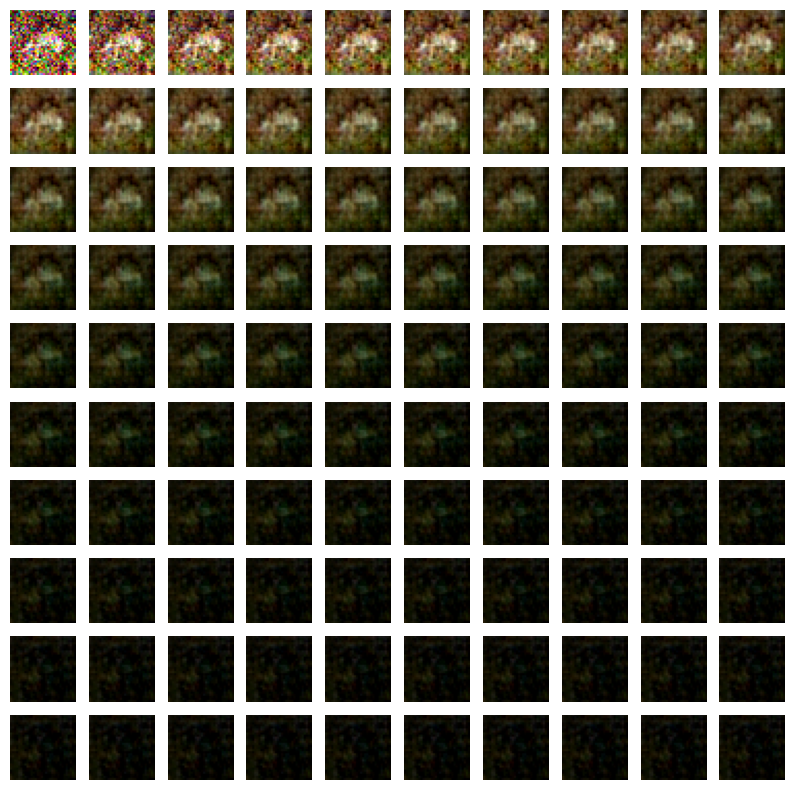

Final MSE:  0.33413833379745483
Final VFE:  0.00029095320496708155
Min MSE:  0.016858255490660667
Min VFE:  0.00023539728135801852


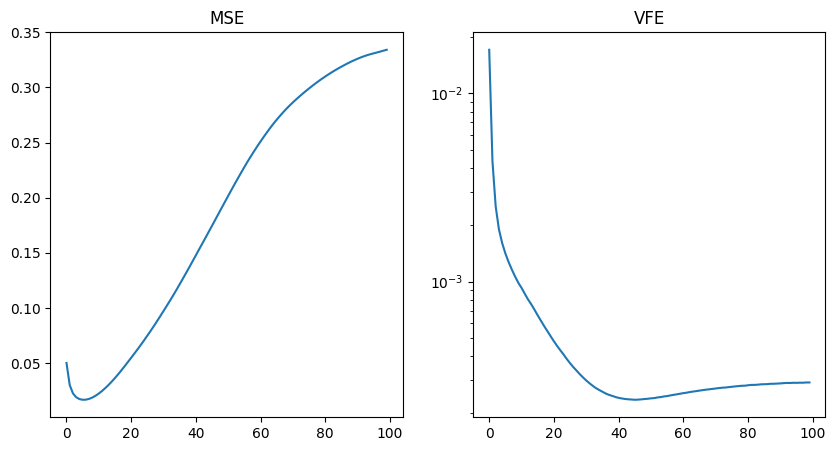

In [23]:
model.eval()
og = train_dataset.images[0].clone().unsqueeze(0)
x = og.clone() + torch.randn_like(og) * 0.3
# x[torch.rand_like(x) > 0.7] = 0.0
# errs = [F.mse_loss(x, og).item()]
vfes = []
errs = []


# Plot the first 1st digit after multiple steps
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes):
    for j, ax2 in enumerate(ax):
        img = x.cpu().squeeze(0).permute(1, 2, 0).detach()
        # img = (F.normalize(x.cpu(), 1).reshape(28,28).detach() - F.normalize(og.cpu(), 1).reshape(28,28).detach()).abs()
        ax2.imshow(img)
        x, state = model.reconstruct(x, steps=50)
        errs.append(F.mse_loss(F.normalize(x), F.normalize(og)).item())
        # errs.append(F.mse_loss(x, og).item())
        vfes.append(model.vfe(state).item())
        ax2.axis('off')

plt.show()

print('Final MSE: ', errs[-1])
print('Final VFE: ', vfes[-1])
print('Min MSE: ', min(errs))
print('Min VFE: ', min(vfes))
# Plot MSE and VFE, VFE logarithmically
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(errs)
axes[0].set_title('MSE')
axes[1].plot(vfes)
axes[1].set_yscale('log')
axes[1].set_title('VFE')
plt.show()


In [18]:
classifier = torch.nn.Sequential(
    torch.nn.Linear(20, 10),
).to(device)
class_stats = {
    'epoch': 0,
    'trainLoss': [],
    'valAcc': [],
    'valLoss': [],
}

In [19]:
train_classifier(
    model,
    classifier,
    NUM_EPOCHS,
    train_dataset,
    val_dataset,
    class_stats,
    # eval_every=10,
)

KeyboardInterrupt: 

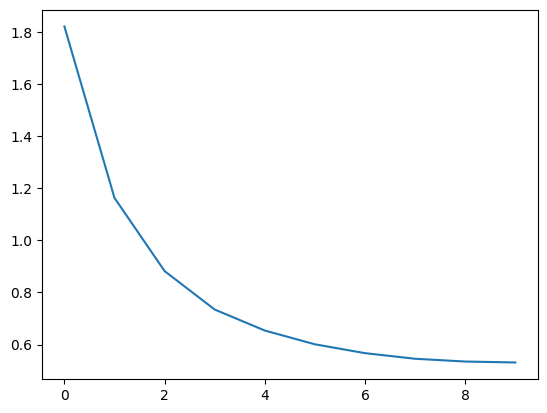

In [20]:
plt.plot(class_stats['trainLoss'], label='trainLoss')

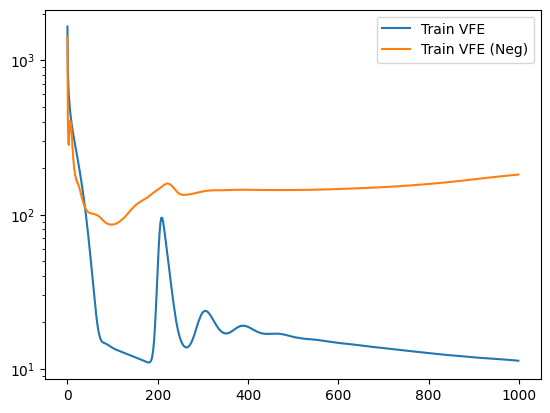

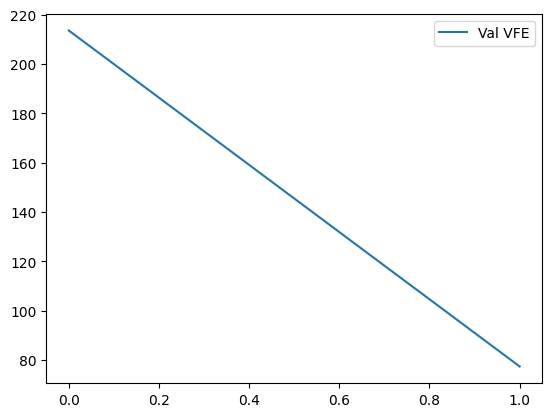

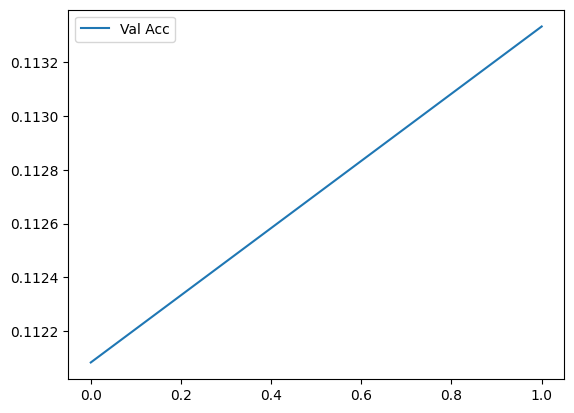

In [11]:
plt.plot(stats['trainVfe'], label='Train VFE')
plt.plot(stats['negVfe'], label='Train VFE (Neg)')
# plt.plot(sameneg_stats['trainVfe'], label='Train VFE (Neg)')
# plt.plot(noneg_nonorm_stats['trainVfe'], label='Train VFE (No Norm)')
plt.legend()
plt.yscale('log')
plt.show()

plt.plot(stats['valVfe'], label='Val VFE')
# plt.plot(stats['valVfe'], label='Val VFE (Neg)')
# plt.plot(noneg_nonorm_stats['valVfe'], label='Val VFE (No Norm)')
plt.legend()
plt.show()

plt.plot(stats['valAcc'], label='Val Acc')
# plt.plot(sameneg_stats['valAcc'], label='Val Acc (Neg)')
# plt.plot(noneg_nonorm_stats['valAcc'], label='Val Acc (No Norm)')
plt.legend()
plt.show()

In [13]:
device = torch.device('cpu')
model = model.to(device)

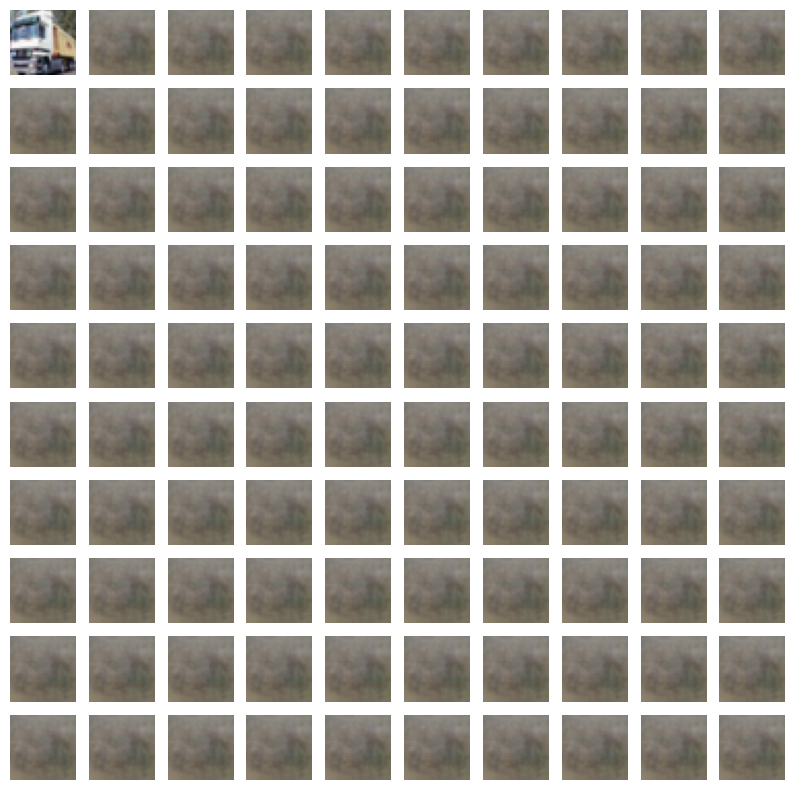